# Reddit Subreddit Classification
## Notebook 3 - Preprocessing and Modeling
---

## Imports

### Libraries

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, FunctionTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, classification_report
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.feature_extraction import text

from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, AdaBoostClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

from datetime import datetime
pd.options.display.max_colwidth = 200

### Data

In [2]:
final_df = pd.read_csv("../data/final.csv")

## Preprocessing
Based on my EDA, I thought that it was worth trying two different attempts at changing the text data prior to modeling.
1. Consolidating words covering certain topics into one word
2. Trying additional stop words

### Consolidating Topic Words

To implement the replacement of all words covering certain topics, I created a function that would run regexs composed to capture tokens covering those topics and replacing them with a single word for that topic.

In [3]:
# Function to convert all tokens covering a topic into one word
def consolidate_topics(X):
#    print("Running consolidate topics")
    # Regexs for topic words
    girl = r"girl[A-Za-z]*(?![0-9])"
    boy_guy = r"boy|guy"
    marriage = r"marr[A-Za-z]*"
    divorce = r"divo[A-Za-z]*"
    over_forty = r"\A[4-7][0-9]\Z|\A[4-7][0-9](?!pm|min)[^0-9k]"
    under_forty = r"\A[2-3][0-9]\Z|\A[2-3][0-9](?!pm|min)[^0-9k]"
    kids = r"\Akid[s]?\Z|kiddo|child|\Ason[s]?\Z|daughter|grandkid|grandchild|grandson"
    school = r"\Aschool|college|universi"

    # Tokenize per sklearn's regex sequence
    X = X.str.findall(r"(?u)\b\w\w+\b").apply(lambda x: " ".join(x))

    # Replace all different variations of topic with one word
    X = X.str.replace(girl, "girl", regex=True)
    X = X.str.replace(boy_guy, "boy", regex=True)
    X = X.str.replace(marriage, "marriage", regex=True)
    X = X.str.replace(divorce, "divorce", regex=True)
    X = X.str.replace(over_forty, "over_forty", regex=True)
    X = X.str.replace(under_forty, "under_forty", regex=True)
    X = X.str.replace(kids, "child", regex=True)
    X = X.str.replace(school, "school", regex=True)    
    return X

In [4]:
# Create FunctionTransformer with the consolidate_topics function
consolidate_tf = FunctionTransformer(consolidate_topics, validate=False)

### Additional Stop Words
The stop words below were found during EDA and will be tried out during model gridsearches.

In [5]:
# Common words found during EDA that may work as stop words
add_stop_words = ["just", "like", "date", "dating", "ve", "want", 
                  "time", "relationship", "think", "feel", "people", 
                  "don", "really", "know", "said", "didn", "things",
                 "going", "good", "person"]

# Adding additional stop words to default stop words in sklearn's text vectorizer
new_stop_words = text.ENGLISH_STOP_WORDS.union(add_stop_words)

## Modeling
I performed all model fitting using cloud computing instead of on my local computer to speed up the process. The following code was exported to a python file and ran using a python console.

### GridSearch Function
The following function was used to run grid searches for each model. The function takes in a dictionary of parameters that specifies all the parameters and the model to use for a gridsearch. It then outputs the cv_results_ and the best scores from the gridsearch to the './gridsearch_results' folder as a csv.

In [6]:
def run_gridsearch(X_train, X_test, y_train, y_test, parameters):
    # Create empty list to collect pipeline items
    pipeline_items = []
    
    # If parameters says to consolidate topic words, add topic word replacement function into pipeline
    if parameters["consolidate_text"]:
        pipeline_items.append(("consolidate", consolidate_tf))
    
    # If parameters specifies a vectorizer, add the vectorizer
    if parameters['vec']:
        pipeline_items.append(("vec", parameters['vec']))
    
    # If parameters says to add StandardScaler, add it
    if parameters['ss']:
        pipeline_items.append(("ss", StandardScaler()))
    
    # Add estimator specified in parameters
    pipeline_items.append(("estimator", parameters['estimator']))

    # Instantiate pipeline for gridsearch
    pipe = Pipeline(pipeline_items)
    
    # Add hyper-parameters to grid search over from parameters
    gridsearch_params = parameters['params']
    
    # Instantiate GridSearchCV
    gs = GridSearchCV(estimator=pipe, param_grid=gridsearch_params, n_jobs=-1, verbose = 4)

    # Fit GridSearch
    gs.fit(X_train, y_train)

    # Write cv_results_ and best scores from grid search to csv
    pd.DataFrame(gs.cv_results_).to_csv(f"./gridsearch_results/{parameters['name']}-{datetime.now()}.csv", index=False)
    pd.DataFrame({"train": gs.score(X_train, y_train), "test": gs.score(X_test,y_test)}, index=["best_scores"]).to_csv(f"./gridsearch_results/best_scores_{parameters['name']}-{datetime.now()}.csv", index=False)
    
    return gs

### X and y

In [7]:
X = final_df["alltext"]
y = final_df["||__target__||"]

### Train test split

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y)

### Model Parameters
The following dictionaries set forth the parameters for each of the models I ran using the run_gridsearch function above.

#### Logistic Regression Models

In [9]:
# Logistic regression model with consolidate text function, and TfidfVectorizer
log_reg_con_tf_params = {
    "name": "logistic_regression_consolidate_tfidf",
    "consolidate_text": True,
    "ss": False,
    "vec": TfidfVectorizer(),
    "estimator": LogisticRegression(solver="liblinear"),
    "params": {
        "vec__stop_words": [None, new_stop_words],
        "vec__min_df": [2],
        "vec__max_features": [None, 5000],
        "vec__binary": [False, True],
        "estimator__penalty": ["l1", "l2"],
        "estimator__C": [0.1,1,10],
        "estimator__max_iter": [10000]
    }
}

# Logistic regression model with consolidate text function and CountVectorizer
log_reg_con_count_params = {
    "name": "logistic_regression_consolidate_count",
    "consolidate_text": True,
    "ss": False,
    "vec": CountVectorizer(),
    "estimator": LogisticRegression(solver="liblinear"),
    "params": {
        "vec__stop_words": [None, "english", new_stop_words],
        "vec__min_df": [2, 10],
        "vec__max_features": [None, 5000],
        "vec__binary": [False, True],
        "estimator__penalty": ["l1", "l2"],
        "estimator__C": [0.01,0.1,1,10],
        "estimator__max_iter": [10000]
    }
}

# Logistic regression model without consolidate_text function and with TfidfVectorizer
log_reg_tf_params = {
    "name": "logistic_regression_tfidf",
    "consolidate_text": False,
    "ss": False,
    "vec": TfidfVectorizer(),
    "estimator": LogisticRegression(solver="liblinear"),
    "params": {
        "vec__stop_words": [None, new_stop_words],
        "vec__min_df": [2, 10],
        "vec__max_features": [None, 5000],
        "vec__binary": [False, True],
        "estimator__penalty": ["l1", "l2"],
        "estimator__C": [0.01,0.1,1,10],
        "estimator__max_iter": [10000]
    }
}

# Logistic regression model without consolidate_text function and with CountVectorizer
log_reg_count_params = {
    "name": "logistic_regression_count",
    "consolidate_text": False,
    "ss": False,
    "vec": CountVectorizer(),
    "estimator": LogisticRegression(solver="liblinear"),
    "params": {
        "vec__stop_words": [None, new_stop_words],
        "vec__min_df": [2, 10],
        "vec__max_features": [None, 5000],
        "vec__binary": [False, True],
        "estimator__penalty": ["l1", "l2"],
        "estimator__C": [0.01,0.1,1,10],
        "estimator__max_iter": [10000]
    }
}

#### Multinomial Naive Bayes Models

In [10]:
# Multinomial Naive Bayes model with consolidate_text and TfidfVectorizer
mnb_con_tf_params = {
    "name": "mnb_consolidate_tfidf",
    "consolidate_text": True,
    "ss": False,
    "vec": TfidfVectorizer(),
    "estimator": MultinomialNB(),
    "params": {
        "vec__stop_words": [None, "english", new_stop_words],
        "vec__min_df": [1, 2, 5],
        "vec__max_features": [None, 5000, 10000],
        "vec__binary": [False, True],
        "estimator__alpha": [0, 0.1, 0.5, 1]
    }
}

# Multinomial Naive Bayes model with consolidate_text and CountVectorizer
mnb_con_count_params = {
    "name": "mnb_consolidate_count",
    "consolidate_text": True,
    "ss": False,
    "vec": CountVectorizer(),
    "estimator": MultinomialNB(),
    "params": {
        "vec__stop_words": [None, "english", new_stop_words],
        "vec__min_df": [1, 2, 5],
        "vec__max_features": [None, 5000, 10000],
        "vec__binary": [False, True],
        "estimator__alpha": [0, 0.1, 0.5, 1]
    }
}

# Multinomial Naive Bayes model without consolidate_text and TfidfVectorizer
mnb_tf_params = {
    "name": "mnb_tfidf",
    "consolidate_text": False,
    "ss": False,
    "vec": TfidfVectorizer(),
    "estimator": MultinomialNB(),
    "params": {
        "vec__stop_words": [None, "english", new_stop_words],
        "vec__min_df": [1, 2, 5],
        "vec__max_features": [None, 5000, 10000],
        "vec__binary": [False, True],
        "estimator__alpha": [0, 0.1, 0.5, 1]
    }
}

# Multinomial Naive Bayes model without consolidate_text and CountVectorizer
mnb_count_params = {
    "name": "mnb_count",
    "consolidate_text": False,
    "ss": False,
    "vec": CountVectorizer(),
    "estimator": MultinomialNB(),
    "params": {
        "vec__stop_words": [None, "english", new_stop_words],
        "vec__min_df": [1, 2, 5],
        "vec__max_features": [None, 5000, 10000],
        "vec__binary": [False, True],
        "estimator__alpha": [0, 0.1, 0.5, 1]
    }
}

#### Random Forest Classifier Models

In [11]:
# Random Forest Classifer Model with consolidate_text and TfidfVectorizer
rf_params = {
    "name": "rf",
    "consolidate_text": True,
    "ss": False,
    "vec": TfidfVectorizer(),
    "estimator": RandomForestClassifier(random_state=42),
    "params": {
        "vec__stop_words": [None, new_stop_words],
        "vec__min_df": [2, 5],
        "vec__max_features": [None, 5000],
        "vec__binary": [False, True],
        "estimator__n_estimators": [50, 150],
        "estimator__max_depth": [None, 5, 9],
        "estimator__min_samples_leaf": [3, 7]
    }
}

#### Ada Boost Classifier Models

In [12]:
# Ada Boost Classifier with consolidate_text and TfidfVectorizer
ada_params = {
    "name": "ada",
    "consolidate_text": True,
    "ss": False,
    "vec": TfidfVectorizer(),
    "estimator": AdaBoostClassifier(base_estimator=DecisionTreeClassifier(), random_state=42),
    "params": {
        "vec__stop_words": [None, new_stop_words],
        "vec__min_df": [2, 5],
        "vec__max_features": [None, 5000],
        "vec__binary": [False, True],
        "estimator__n_estimators": [50, 150, 250],
        "estimator__base_estimator__max_depth": [None, 5, 9],
        "estimator__base_estimator__min_samples_leaf": [1, 3, 7]
    }
}

#### Support Vector Machine Models

Because the support vector machine classifier requires scaled data, the text vectorized by TfidfVectorizer needed to be converted from a sparse matrix into a dense matrix before running it through Standard Scaler. The following function addresses that issue.

In [13]:
# Function to vectorize text data before scaling
def vectorize_text(X):
    # Create copy of X
    df_copy = X.copy()
    
    # Run consolidate topics function
    df_copy = consolidate_topics(df_copy)
    
    # Instantiate TfidfVectorizer with 
    vec = TfidfVectorizer(
            stop_words = new_stop_words,
            max_features = None,
            ngram_range = (1,1),
            min_df = 2,
        )

    
    df_vec_sparse = vec.fit_transform(df_copy)
    df_vec = pd.DataFrame(df_vec_sparse.todense(), columns=vec.get_feature_names())
    return df_vec

##### SVM X and y

In [14]:
# Declare X and y for SVM model
X_svm = vectorize_text(final_df["alltext"])
y_svm = final_df["||__target__||"]

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


##### Train test split for SVM

In [15]:
# Train test split for SVM data
X_svm_train, X_svm_test, y_svm_train, y_svm_test = train_test_split(X_svm, y_svm, random_state=42, stratify=y)

In [16]:
# SVM Classifier Parameters for run_gridsearch function

svm_params = {
    "name": "svm",
    "consolidate_text": False,
    "ss": True,
    "vec": False,
    "estimator": SVC(),
    "params": {
        "estimator__C": [1, 10],
        "estimator__kernel": ["rbf"],
#        "estimator__degree": [2, 3],
        "estimator__gamma": ["scale", "auto"]
    }
}

## Conclusion and Recommendations

### Model Evaluation

#### Baseline Accuracy Score
The baseline accuracy score to compare our model against is shown below by showing the percentage of the observations in our dataset that are classified as class 1.

In [17]:
final_df["||__target__||"].value_counts(normalize=True)

0    0.5
1    0.5
Name: ||__target__||, dtype: float64

Because we balanced the classes during the import and cleaning of our data at the start, we have a baseline accuracy score of 50%.

#### Best Model on Accuracy
Of all the models tested through our grid searches, it appears that the logistic regression and Multinomial Naive Bayes classifier models performed the best. Although overfit, they achieved the best accuracy scores on our test set.

In [18]:
# Extract scores written to CSV during gridsearches
# Filenames of the CSVs correspond with the model and set of parameters used for the gridsearch during which the CSV was written

best_scores = []
for file in os.listdir("../gridsearch_results"):
    if file.split("_")[0] == "best":
        before_timestamp = file.split("-")[0]
        df = pd.read_csv(f'../gridsearch_results/{file}')
        df['gridsearch'] = before_timestamp.split("_", 2)[-1]
        best_scores.append(df)
all_scores = pd.concat(best_scores).reset_index(drop=True)

In [19]:
# Show best scores achieved by each gridsearch sorted by scores on the test set
all_scores[["gridsearch", "train", "test"]].sort_values(by="test", ascending=False)

,gridsearch,train,test
2,logistic_regression_consolidate_tfidf,0.909395,0.820244
0,logistic_regression_tfidf,0.911576,0.818499
3,logistic_regression_count,0.918994,0.811518
5,logistic_regression_consolidate_count,0.918557,0.810209
1,mnb_count,0.866492,0.806283
4,mnb_consolidate_count,0.863583,0.805846
7,mnb_tfidf,0.880454,0.800175
8,rf,0.895870,0.799738
9,mnb_consolidate_tfidf,0.879290,0.799738
10,ada,0.999709,0.745201


Among these, I believe the Logistic Regression model using our consolidate text function and a TfidfVectorizer is our best model as it achieved the best score on our test set -- 82.02%. I believe this means that this model is the most likely to generalize well and achieve similar accuracy results in classifying new posts from the subreddits.

#### Other Metrics

Our best model also achieves similar scores on other evaluation metrics:

1. Weighted avg precision: 82%
2. Weighted avg recall: 82%
3. F1 score: 82%

The code for evaluating our model on these metrics is provided below.

In [ ]:
# Instantiate pipe
pipe_best_model = Pipeline([
    ("consolidate", consolidate_tf),
    ("vec", TfidfVectorizer()),
    ("estimator", LogisticRegression(solver='liblinear'))
])

gs_params_best_model = {
    "vec__stop_words": [None, new_stop_words],
    "vec__min_df": [2, 5],
    "vec__max_features": [None, 5000],
    "vec__binary": [False, True],
    "estimator__penalty": ["l1", "l2"],
    "estimator__C": [0.1,1,10],
    "estimator__max_iter": [10000]
}

# Instantiate GridSearchCV
gs = GridSearchCV(estimator=pipe_best_model, param_grid=gs_params_best_model, n_jobs=-1)

# Fit GridSearch
gs.fit(X_train, y_train)

In [ ]:
final_model = gs

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


Running consolidate topics


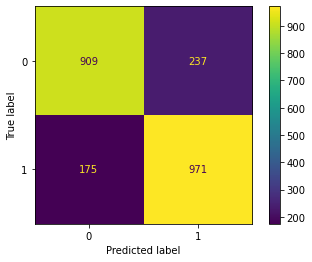

In [252]:
# Plot confusion matrix
plot_confusion_matrix(final_model, X_test, y_test);

In [253]:
# Create predictions on test set
predictions_test = final_model.predict(X_test)

# Print classification report
print(classification_report(y_test, predictions_test));

Running consolidate topics
              precision    recall  f1-score   support

           0       0.84      0.79      0.82      1146
           1       0.80      0.85      0.82      1146

    accuracy                           0.82      2292
   macro avg       0.82      0.82      0.82      2292
weighted avg       0.82      0.82      0.82      2292



### Recommendations

To improve upon the accuracy of this model, I would recommend exploring the following next steps:
1. Adding more features about the text
    - Sentiment analysis on each post
    - Counts of the number of words and sentences used in each post
2. Exploring other natural language processing strategies to differentiate the subreddits further